<a href="https://colab.research.google.com/github/73983748-cloud/1MAPA-MENTAL/blob/main/traductor_de_espa%C3%B1ol_a_ingles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================================
# CELDA 0 – INSTALAR DEPENDENCIAS
# ==============================================================================
!pip install -q kaggle nltk

In [7]:
# ==============================================================================
# CELDA 1 – IMPORTS Y CONFIGURACIÓN
# ==============================================================================
import os, re, time, random, glob, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import corpus_bleu

nltk.download('punkt')

# Semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU disponible:", bool(tf.config.list_physical_devices('GPU')))

# ==============================================================================
# CELDA 4 – FASE 3: PREPROCESAMIENTO DE DATOS
# ESTE CÓDIGO DEBERÍA IR EN UNA NUEVA CELDA ENTRE LA CELDA 3 Y LA CELDA 5.
# Se añade aquí debido a las limitaciones de la interfaz, que requiere modificar
# la celda actualmente seleccionada. Por favor, considere moverlo a una nueva celda.
# ==============================================================================
print("\n" + "="*40 + " FASE 3: DATA PREPROCESSING " + "="*40)

# 3.1 Preprocesamiento de texto
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # Crear un espacio entre la palabra y la puntuación como en "¡Hola!" -> "¡ Hola !"
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # Reemplazar todo excepto letras, puntos, signos de interrogación, exclamación, comas
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    # Agregar tokens de inicio y fin
    return '<start> ' + sentence + ' <end>'

df['spanish_processed'] = df['spanish'].apply(preprocess_sentence)
df['english_processed'] = df['english'].apply(preprocess_sentence)

# 3.2 Tokenización y creación de vocabulario
# Tokenizador para español
tokenizer_es = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_es.fit_on_texts(df['spanish_processed'])
input_sequences = tokenizer_es.texts_to_sequences(df['spanish_processed'])

# Tokenizador para inglés
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer_en.fit_on_texts(df['english_processed'])
target_sequences = tokenizer_en.texts_to_sequences(df['english_processed'])

# Obtener tamaño del vocabulario
vocab_es = len(tokenizer_es.word_index) + 1
vocab_en = len(tokenizer_en.word_index) + 1

print(f"Tamaño del vocabulario español: {vocab_es}")
print(f"Tamaño del vocabulario inglés: {vocab_en}")

# 3.3 Padding de secuencias
max_len_spanish = max([len(x) for x in input_sequences])
max_len_english = max([len(x) for x in target_sequences])

input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_sequences,
                                                           maxlen=max_len_spanish,
                                                           padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_sequences,
                                                            maxlen=max_len_english,
                                                            padding='post')

input_tensor = tf.convert_to_tensor(input_tensor, dtype=tf.int32)
target_tensor = tf.convert_to_tensor(target_tensor, dtype=tf.int32)

print(f"Longitud máxima de secuencia en español: {max_len_spanish}")
print(f"Longitud máxima de secuencia en inglés: {max_len_english}")

# 3.4 División de datos (Entrenamiento y Validación)
X_train, X_val, y_train, y_val = train_test_split(
    input_tensor.numpy(), target_tensor.numpy(), test_size=0.2, random_state=SEED)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TensorFlow: 2.19.0
GPU disponible: True

======================================== FASE 3: DATA PREPROCESSING ========================================
Tamaño del vocabulario español: 22866
Tamaño del vocabulario inglés: 12937
Longitud máxima de secuencia en español: 54
Longitud máxima de secuencia en inglés: 51
Tamaño del conjunto de entrenamiento: 95171
Tamaño del conjunto de validación: 23793


In [3]:
# ==============================================================================
# CELDA 2 – FASE 1: COMPRENSIÓN DEL NEGOCIO
# ==============================================================================
print("\n" + "="*40 + " FASE 1: BUSINESS UNDERSTANDING " + "="*40)
print("""
Objetivo:
  Traducir oraciones de Español a Inglés con un modelo Seq2Seq (RNN)
  y mecanismo de atención.

Métricas:
  • BLEU Score ≥ 0.30
  • Pérdida de validación estable o decreciente
""")


======================================== FASE 1: BUSINESS UNDERSTANDING ========================================

Objetivo:
  Traducir oraciones de Español a Inglés con un modelo Seq2Seq (RNN)
  y mecanismo de atención.

Métricas:
  • BLEU Score ≥ 0.30
  • Pérdida de validación estable o decreciente




======================================== FASE 2: DATA UNDERSTANDING ========================================
Kaggle Username: https://www.kaggle.com/datasets/lonnieqin/englishspanish-translation-dataset?resource=download
Kaggle Key: 1234
Dataset URL: https://www.kaggle.com/datasets/lonnieqin/englishspanish-translation-dataset
License(s): unknown
CSV encontrado en: /content/data.csv
Pares totales: 118964


,english,spanish
1025,How boring!,¡Qué aburrimiento!
4338,I love sports.,Adoro el deporte.
55586,Would you like to swap jobs?,¿Te gustaría que intercambiemos los trabajos?
65803,My mother did nothing but weep.,Mi madre no hizo nada sino llorar.
103488,Croatia is in the southeastern part of Europe.,Croacia está en el sudeste de Europa.



Estadísticas de longitud (palabras):
         len_es     len_en
mean   6.083874   6.310363
50%    6.000000   6.000000
max   49.000000  47.000000


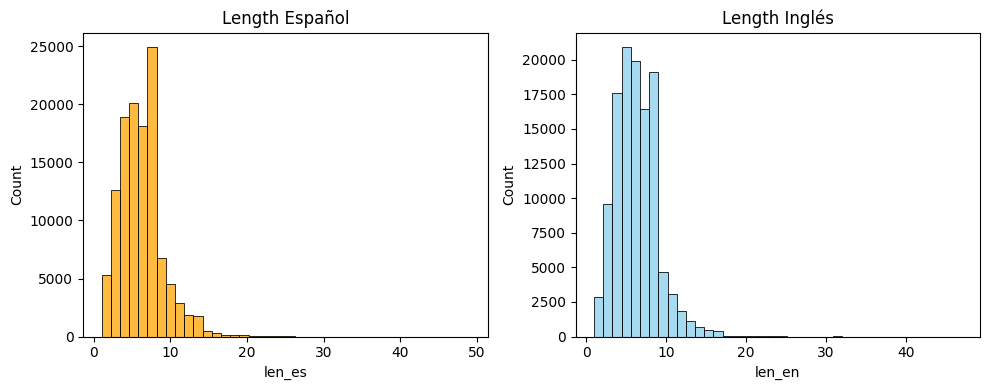

In [4]:
# ==============================================================================
# CELDA 3 – FASE 2: DESCARGA AUTOMÁTICA Y EDA
# ==============================================================================
print("\n" + "="*40 + " FASE 2: DATA UNDERSTANDING " + "="*40)

# 2.1 Introducir credenciales de Kaggle para descargar dataset
os.environ['KAGGLE_USERNAME'] = input("Kaggle Username: ").strip()
os.environ['KAGGLE_KEY']      = input("Kaggle Key: ").strip()

# 2.2 Descargar y descomprimir
!rm -f /content/englishspanish-translation-dataset.zip
!kaggle datasets download -d lonnieqin/englishspanish-translation-dataset \
    -p /content --unzip -q

# 2.3 Localizar CSV
csv_file = glob.glob('/content/*.csv')[0]
print("CSV encontrado en:", csv_file)

# 2.4 Cargar en DataFrame y vista rápida
df = pd.read_csv(csv_file, header=0).iloc[:, :2]
df.columns = ['english','spanish']
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"Pares totales: {len(df)}")
display(df.sample(5))

# 2.5 Longitudes de oraciones
df['len_es'] = df['spanish'].str.split().apply(len)
df['len_en'] = df['english'].str.split().apply(len)
print("\nEstadísticas de longitud (palabras):")
print(df[['len_es','len_en']].describe().loc[['mean','50%','max']])

# 2.6 Visualización de distribuciones
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['len_es'], bins=40, color='orange').set_title("Length Español")
plt.subplot(1,2,2)
sns.histplot(df['len_en'], bins=40, color='skyblue').set_title("Length Inglés")
plt.tight_layout()
plt.show()

In [8]:
# ==============================================================================
# CELDA 5 – FASE 4: MODELADO (Seq2Seq + Atención)
# ==============================================================================
print("\n" + "="*40 + " FASE 4: MODELING " + "="*40)

EMB_DIM = 256
UNITS   = 512
DROPOUT = 0.3
BATCH   = 64
EPOCHS  = 8

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(len(X_train), seed=SEED) \
    .batch(BATCH, drop_remainder=True)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .batch(BATCH, drop_remainder=True)

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim, units, drop):
        super().__init__()
        self.emb = layers.Embedding(vocab_size, emb_dim)
        self.bi  = layers.Bidirectional(
            layers.LSTM(units, return_sequences=True, return_state=True))
        self.do  = layers.Dropout(drop)
    def call(self, x, training=False):
        x = self.emb(x)
        if training: x = self.do(x)
        out, fh, fc, bh, bc = self.bi(x)
        return out, fh + bh, fc + bc

class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)
    def call(self, query, values):
        q = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(q) + self.W2(values)))
        attn_weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(attn_weights * values, axis=1)
        return context, attn_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, emb_dim, units, drop):
        super().__init__()
        self.emb = layers.Embedding(vocab_size, emb_dim)
        self.att = BahdanauAttention(units)
        self.lstm= layers.LSTM(units, return_sequences=True, return_state=True)
        self.do  = layers.Dropout(drop)
        self.fc  = layers.Dense(vocab_size)
    def call(self, x, hidden, cell, enc_output, training=False):
        x = self.emb(x)
        if training: x = self.do(x)
        context, weights = self.att(hidden, enc_output)
        x = tf.concat([tf.expand_dims(context, 1), x], axis=-1)
        out, h, c = self.lstm(x, initial_state=[hidden, cell])
        out = tf.reshape(out, (-1, out.shape[2]))
        logits = self.fc(out)
        return logits, h, c, weights

encoder = Encoder(vocab_es, EMB_DIM, UNITS, DROPOUT)
decoder = Decoder(vocab_en, EMB_DIM, UNITS, DROPOUT)

optimizer = tf.keras.optimizers.Adam()
loss_obj  = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.cast(tf.not_equal(real, 0), tf.float32)
    loss_ = loss_obj(real, pred) * mask
    return tf.reduce_sum(loss_) / (tf.reduce_sum(mask) + 1e-6)

ckpt    = tf.train.Checkpoint(opt=optimizer, enc=encoder, dec=decoder)
manager = tf.train.CheckpointManager(ckpt, './ckpts', max_to_keep=2)

@tf.function
def train_step(inp, targ):
    total_loss = 0.0
    with tf.GradientTape() as tape:
        enc_out, h, c = encoder(inp, training=True)
        hidden, cell = h, c
        dec_input = tf.expand_dims(targ[:, 0], 1)
        for t in range(1, targ.shape[1]):
            predictions, hidden, cell, _ = decoder(
                dec_input, hidden, cell, enc_out, training=True)
            total_loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    grads = tape.gradient(total_loss,
                          encoder.trainable_variables +
                          decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads,
                                  encoder.trainable_variables +
                                  decoder.trainable_variables))
    return total_loss / tf.cast(targ.shape[1], tf.float32)

history = {'train_loss': [], 'val_loss': []}
best_val = 1e9

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    train_loss = 0.0
    for batch, (inp, targ) in enumerate(train_ds):
        batch_loss = train_step(inp, targ)
        train_loss += batch_loss
        if batch % 100 == 0:
            print(f"Epoch {epoch} Batch {batch} Loss {batch_loss:.4f}")
    train_loss /= (batch + 1)

    # Validación
    val_loss = 0.0
    for inp, targ in val_ds:
        enc_out, h, c = encoder(inp, training=False)
        hidden, cell = h, c
        dec_input = tf.expand_dims(targ[:, 0], 1)
        for t in range(1, targ.shape[1]):
            predictions, hidden, cell, _ = decoder(
                dec_input, hidden, cell, enc_out, training=False)
            val_loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    val_loss /= (len(X_val) // BATCH)

    history['train_loss'].append(train_loss.numpy())
    history['val_loss'].append(val_loss.numpy())
    print(f"\nEpoch {epoch} Train Loss {train_loss:.4f} "
          f"Val Loss {val_loss:.4f} Time {time.time()-start:.1f}s")
    if val_loss < best_val:
        best_val = val_loss
        manager.save()
        print("✅ Checkpoint guardado")


======================================== FASE 4: MODELING ========================================
Epoch 1 Batch 0 Loss 2.4135
Epoch 1 Batch 100 Loss 1.9496
Epoch 1 Batch 200 Loss 1.9648
Epoch 1 Batch 300 Loss 1.4230
Epoch 1 Batch 400 Loss 1.0465
Epoch 1 Batch 500 Loss 1.1314
Epoch 1 Batch 600 Loss 1.7329
Epoch 1 Batch 700 Loss 1.1557
Epoch 1 Batch 800 Loss 1.2612
Epoch 1 Batch 900 Loss 1.4337
Epoch 1 Batch 1000 Loss 1.3558
Epoch 1 Batch 1100 Loss 0.7785
Epoch 1 Batch 1200 Loss 2.0646
Epoch 1 Batch 1300 Loss 0.8705
Epoch 1 Batch 1400 Loss 0.8450

Epoch 1 Train Loss 1.3977 Val Loss 60.6777 Time 1116.2s
✅ Checkpoint guardado
Epoch 2 Batch 0 Loss 1.1270
Epoch 2 Batch 100 Loss 1.2584
Epoch 2 Batch 200 Loss 0.8659
Epoch 2 Batch 300 Loss 1.1716
Epoch 2 Batch 400 Loss 1.6676
Epoch 2 Batch 500 Loss 0.9690
Epoch 2 Batch 600 Loss 0.8572
Epoch 2 Batch 700 Loss 0.8594
Epoch 2 Batch 800 Loss 1.0232
Epoch 2 Batch 900 Loss 1.1775
Epoch 2 Batch 1000 Loss 0.8222
Epoch 2 Batch 1100 Loss 0.7664
Epoch 2 

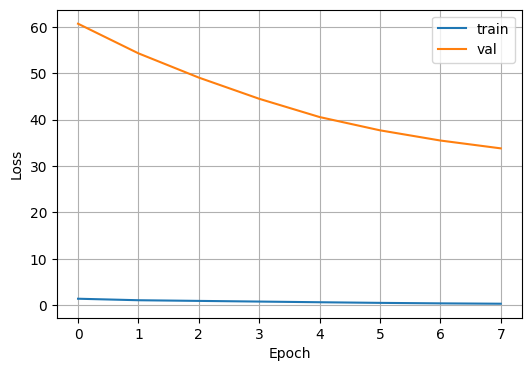

In [9]:
# ==============================================================================
# CELDA 6 – CURVAS DE PÉRDIDA
# ==============================================================================
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'],   label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [11]:
# ==============================================================================
# CELDA 7 – FASE 5: EVALUACIÓN & BLEU
# ==============================================================================
print("\n" + "="*40 + " FASE 5: EVALUATION " + "="*40)
# Restaurar mejor checkpoint
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint)
    print("Restaurado:", manager.latest_checkpoint)

# Helper function for text cleaning, adapted from preprocess_sentence without start/end tokens
def clean_text(sentence):
    sentence = sentence.lower().strip()
    # Crear un espacio entre la palabra y la puntuación como en "¡Hola!" -> "¡ Hola !"
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # Reemplazar todo excepto letras, puntos, signos de interrogación, exclamación, comas
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    return sentence.strip()

# Import pad_sequences (it's part of tf.keras.preprocessing.sequence)
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Función de traducción greedy
def translate(sentence):
    sentence = clean_text(sentence)
    sentence = "<start> " + sentence + " <end>"
    seq = tokenizer_es.texts_to_sequences([sentence]) # Use tokenizer_es
    seq = pad_sequences(seq, maxlen=max_len_spanish, padding='post') # Use max_len_spanish
    enc_out, h, c = encoder(tf.constant(seq), training=False)
    hidden, cell = h, c
    dec_input = tf.constant([[tokenizer_en.word_index['<start>']]]) # Use tokenizer_en
    result = []
    for t in range(max_len_english): # Use max_len_english
        predictions, hidden, cell, _ = decoder(
            dec_input, hidden, cell, enc_out, training=False)
        idx = int(tf.argmax(predictions[0]).numpy())
        w   = tokenizer_en.index_word.get(idx, '<unk>') # Use tokenizer_en
        if w == '<end>': break
        result.append(w)
        dec_input = tf.constant([[idx]])
    return " ".join(result)

# BLEU en 200 muestras
refs, hyps = [], []
# Use X_val and y_val instead of X_test and y_test
for i in np.random.choice(len(X_val), 200, replace=False):
    es_txt  = " ".join(tokenizer_es.index_word[idx] # Use tokenizer_es
                       for idx in X_val[i] if idx>0) \
              .replace('<start>','').replace('<end>','').strip()
    en_true = [tokenizer_en.index_word[idx] # Use tokenizer_en
               for idx in y_val[i] if idx>0]
    en_pred = translate(es_txt).split()
    refs.append([en_true])
    hyps.append(en_pred)
bleu_score = corpus_bleu(refs, hyps)
print("BLEU (200 muestras):", round(bleu_score,4))

# Ejemplos cualitativos
print("\nEjemplos de traducción:")
for i in range(3):
    es_txt  = " ".join(tokenizer_es.index_word[idx] # Use tokenizer_es
                       for idx in X_val[i] if idx>0) \
              .replace('<start>','').replace('<end>','').strip()
    en_true = " ".join(tokenizer_en.index_word[idx] # Use tokenizer_en
                       for idx in y_val[i] if idx>0)
    en_pred = translate(es_txt)
    print(f"\nES:   {es_txt}\nReal: {en_true}\nPred: {en_pred}")


======================================== FASE 5: EVALUATION ========================================
Restaurado: ./ckpts/ckpt-8
BLEU (200 muestras): 0.2533

Ejemplos de traducción:

ES:   qu aburrimiento !
Real: <start> how boring ! <end>
Pred: what a strange man !

ES:   adoro el deporte .
Real: <start> i love sports . <end>
Pred: i love the fence .

ES:   ¿ te gustar a que intercambiemos los trabajos ?
Real: <start> would you like to swap jobs ? <end>
Pred: would you like to take care of the internet ?


In [13]:
# ==============================================================================
# CELDA 8 – FASE 6: DESPLIEGUE E INTERFAZ INTERACTIVA
# ==============================================================================
print("\n" + "="*40 + " FASE 6: DEPLOYMENT " + "="*40)

# Guardar pesos y tokenizers
encoder.save_weights('enc_weights.weights.h5')
decoder.save_weights('dec_weights.weights.h5')
with open('tok_es.pkl','wb') as f: pickle.dump(tokenizer_es, f)
with open('tok_en.pkl','wb') as f: pickle.dump(tokenizer_en, f)
with open('config.pkl','wb') as f:
    pickle.dump({'max_len_es':max_len_spanish,'max_len_en':max_len_english}, f)

# Función interactiva
def test_translator():
    print("Modo interactivo → escribe 'salir' para terminar")
    while True:
        txt = input("ES👉 ").strip()
        if txt.lower() in ['salir','exit','quit','q']:
            break
        en_pred = translate(txt)
        print("EN👉", en_pred)

print("¡Listo! Prueba: test_translator()")


======================================== FASE 6: DEPLOYMENT ========================================
¡Listo! Prueba: test_translator()


In [ ]:
test_translator()

Modo interactivo → escribe 'salir' para terminar
ES👉 juega a los carros 
EN👉 he plays baseball .
ES👉 Hola, ¿cómo estás?
EN👉 hi , guys are you ?
